In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip  '/content/drive/MyDrive/data-Splitted.zip'

# import libraries

In [73]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
from collections import Counter,OrderedDict
import cv2
import torch.nn.functional as F
from torchsummary import summary
from PIL import Image


## Transform the Dataset

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])])
}


# create dataloaders

In [7]:
data_dir = '/content/data-Splitted'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

dirs = {'train': train_dir,
        'valid': valid_dir,
        'test' : test_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x])
                  for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True)
               for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

## count no of sampels for each class

In [17]:
train_classes = [label for _, label in image_datasets['train']]
count=Counter(train_classes)
count

Counter({0: 32,
         1: 36,
         2: 39,
         3: 46,
         4: 38,
         5: 69,
         6: 69,
         7: 39,
         8: 38,
         9: 39,
         10: 32,
         11: 68,
         12: 65,
         13: 39,
         14: 48,
         15: 44,
         16: 32,
         17: 47,
         18: 72,
         19: 33,
         20: 32,
         21: 32,
         22: 32,
         23: 52,
         24: 62,
         25: 32,
         26: 68,
         27: 41,
         28: 36,
         29: 36,
         30: 32,
         31: 34,
         32: 60,
         33: 86,
         34: 44,
         35: 32,
         36: 44,
         37: 53,
         38: 101,
         39: 47,
         40: 104,
         41: 74,
         42: 32,
         43: 156,
         44: 53,
         45: 56,
         46: 39,
         47: 52,
         48: 73,
         49: 206,
         50: 68,
         51: 74,
         52: 48,
         53: 56,
         54: 87,
         55: 53,
         56: 91,
         57: 53,
         58: 36,
   

## plot no of samples for each class

<BarContainer object of 102 artists>

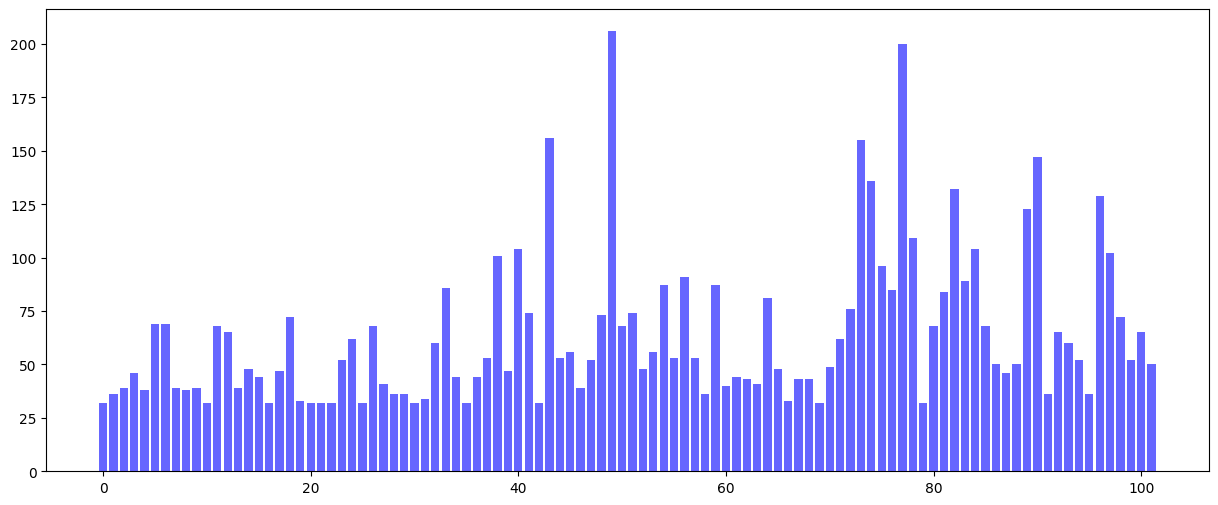

In [18]:
plt.figure(figsize=(15,6))
plt.bar(count.keys(), count.values(),color='b',alpha=.6)


In [19]:
x,y=next(iter(dataloaders['train']))
print(x.shape,y.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


## display some images of dataset

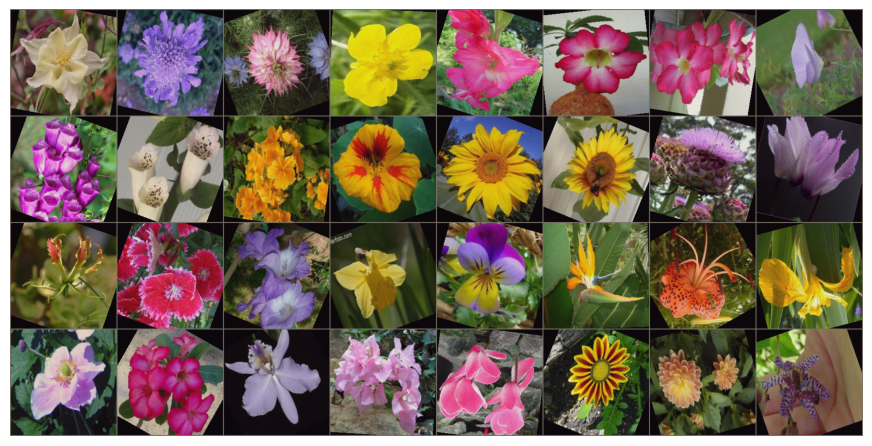

In [20]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(11, 11))
    plt.imshow(image)
    ax.axis('off')

    # Make a grid from batch
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)



## create model

In [22]:
class FFClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 4096)
        self.fc2 = nn.Linear(4096, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Transfer Learning (ResNet50)



In [25]:

model_conv = models.resnet50(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = FFClassifier(num_ftrs, 102)

model_conv = model_conv.to(device)


## train function

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('==> {} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## train the model

In [28]:

# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()

# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
# # Observe that all parameters are being optimized
optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)


# Number of epochs
eps=25
model_ft = train_model(model_conv, criteria, optimizer, sched, eps, device)

Epoch 0/24
----------
==> train Loss: 2.5376 Accuracy: 0.4142
==> valid Loss: 1.4372 Accuracy: 0.6065

Epoch 1/24
----------
==> train Loss: 1.0820 Accuracy: 0.7060
==> valid Loss: 0.9653 Accuracy: 0.7213

Epoch 2/24
----------
==> train Loss: 0.7795 Accuracy: 0.7778
==> valid Loss: 0.7580 Accuracy: 0.7755

Epoch 3/24
----------
==> train Loss: 0.6283 Accuracy: 0.8171
==> valid Loss: 0.7549 Accuracy: 0.7652

Epoch 4/24
----------
==> train Loss: 0.5821 Accuracy: 0.8296
==> valid Loss: 0.7448 Accuracy: 0.7845

Epoch 5/24
----------
==> train Loss: 0.5079 Accuracy: 0.8440
==> valid Loss: 0.6097 Accuracy: 0.8142

Epoch 6/24
----------
==> train Loss: 0.4695 Accuracy: 0.8615
==> valid Loss: 0.6246 Accuracy: 0.8103

Epoch 7/24
----------
==> train Loss: 0.4540 Accuracy: 0.8681
==> valid Loss: 0.6082 Accuracy: 0.8271

Epoch 8/24
----------
==> train Loss: 0.3848 Accuracy: 0.8875
==> valid Loss: 0.5559 Accuracy: 0.8413

Epoch 9/24
----------
==> train Loss: 0.3864 Accuracy: 0.8826
==> valid L

## save model

In [46]:
model_conv.class_to_idx = image_datasets['train'].class_to_idx
model_conv.cpu()
torch.save({'arch': 'resnet50',
            'state_dict': model_conv.state_dict(),
            'class_to_idx': model_conv.class_to_idx},
            '/content/drive/MyDrive/classifier_V2.pth')

## load the model

In [40]:

def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)

    if chpt['arch'] == 'resnet50':
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

        model.class_to_idx = chpt['class_to_idx']
        num_ftrs = model.fc.in_features
        model.fc = FFClassifier(num_ftrs, 102)
        model.load_state_dict(chpt['state_dict'])

        return model

model = load_model('/content/drive/MyDrive/classifier_V2.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## summary of the model

In [44]:
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## calculate accuracy for some classes in test data

In [66]:
def calc_accuracy(model, data, cuda=True):

    model.eval()
    model.to(device)

    combined_predictions = []
    combined_true_labels = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            # obtain the outputs from the model
            outputs = model.forward(inputs)

            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)

            # check the
            if idx == 0:
                print("predicted class: ", predicted) #the predicted class
                print("predicted probability: ", torch.exp(_)) # the predicted probability

            predicted == labels.data

            combined_predictions = combined_predictions + list(predicted)
            combined_true_labels = combined_true_labels + list(labels.data)

    combined_predictions = [int(i) for i in combined_predictions]
    combined_true_labels = [int(i) for i in combined_true_labels]

    return combined_predictions, combined_true_labels

In [67]:
predictions, true_labels = calc_accuracy(model, 'test', True)


predicted class:  tensor([ 64,  61,  73,  84,  39,  42,  21,  99,  97,  33,  31,  33,  65, 101,
         33,  78,  71,  20,  49,  70,  18,  29,  71,  78,  11,  55,  29,  59,
         78,   2,  38,  45], device='cuda:0')
predicted probability:  tensor([1.0000, 0.5542, 0.9872, 0.6935, 0.4999, 0.7914, 0.9326, 0.9994, 0.9996,
        0.9983, 0.9999, 1.0000, 0.9989, 1.0000, 1.0000, 0.9999, 0.9994, 1.0000,
        0.9983, 0.9328, 1.0000, 0.3763, 0.9975, 0.9997, 0.9862, 0.8544, 0.9931,
        1.0000, 0.9950, 1.0000, 0.9952, 0.5465], device='cuda:0')


# total test accuracy

In [63]:
correct = 0
total = 0
with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders['test']):
            inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 85 %


## process the test image as test transformer

In [68]:
def process_image(image):
    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

    ## Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd

# predict function for new data

In [101]:
def predict(image_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Implement the code to predict the class from an image file
    np.set_printoptions(suppress=True)

    # Loading model - using .cpu() for working with CPUs
    loaded_model = model.cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    # Calculating probabilities
    probs = torch.exp(output)
    probs_top = probs.topk(topk)[0]
    index_top = probs.topk(topk)[1]
    # Converting probabilities and outputs to lists
    probs_top_list = np.array(probs_top)[0]
    index_top_list = np.array(index_top[0])
    # Loading index and class mapping
    class_to_idx = loaded_model.class_to_idx
    # Inverting index-class dictionary
    indx_to_class = {x: y for y, x in class_to_idx.items()}

    # Converting index list to class list
    classes_top_list = []
    for index in index_top_list:
        classes_top_list += [indx_to_class[index]]

    return probs_top_list, classes_top_list


## Testing predict function

In [103]:
# Testing predict function

# Inputs are paths to saved model and test image
image_path = '/content/data-Splitted/test/101/image_07976'

probs,classes = predict(image_path, topk=5)
print(probs)
print(classes)

[0.9792302  0.01119215 0.00528464 0.00302066 0.00037197]
['101', '90', '26', '80', '24']


## load class name as strings not numbers

In [106]:
with open('/content/cat_to_name.json', 'r') as f:
    class_name = json.load(f)

## Show the result in test sample

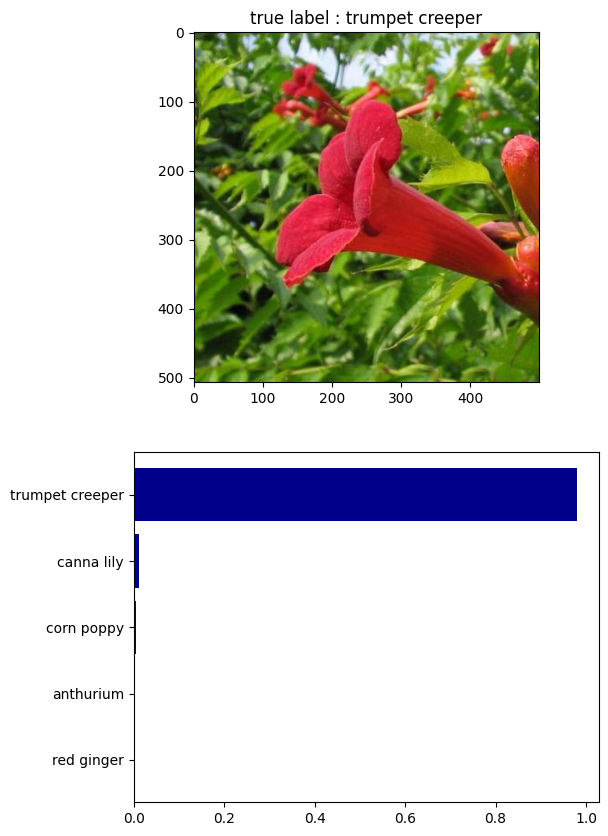

In [112]:
# Converting classes to names
names = []
for i in classes:
    names += [class_name[i]]

# Creating PIL image
image = Image.open(image_path+'.jpg')

# Plotting test image and predicted probabilites
f, ax = plt.subplots(2,figsize = (6,10))

ax[0].imshow(image)
ax[0].set_title("true label : "+names[0])

y_names = np.arange(len(names))
ax[1].barh(y_names, probs, color='darkblue')
ax[1].set_yticks(y_names)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis()

plt.show()


# **Thanks 😊**
